## Код, имеющий отношение к первой Лабораторной работе по курсу Математических Методов Прогнозирования

In [1]:
import json
import numpy as np
import ot
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor as LOF
from scipy.stats import kendalltau

### Загружаем данные

In [2]:
with open('data.json', 'r', encoding='utf8') as fp:
    data = json.load(fp)

### Создаём вспомагательные функции и классы

* `DataProcessor` процессит поступившие данные, по запросу возвращает распределение по фичам/оценкам экспертов

* `show_distrib` - вспомагательная функция, показывает полученное распределение

* `get_w_bary` - подсчитывает Вассерштайн - барицентр нескольких распределений

* `get_w_distance`, `get_w_distances` - подсчитывают расстояния вассерштайна

In [10]:
class DataProcessor:

    def __init__(self, path):
        self.path = path
        with open(self.path, 'r', encoding='utf8') as fp:
            data = json.load(fp)
        self.data = data
    
    def get_product_ids(self, to_str = True):
        products = self.data['products id']
        prod_ids = list(products.values())
        prod_ids.sort()
        if to_str:
            prod_ids = list(map(str, prod_ids))
        return prod_ids
    
    def get_id_prod_dict(self, to_str=True):
        _res = {}
        for key, value in self.data['products id'].items():
            if to_str:
                value = str(value)
            _res[value] = key
        return _res

    def get_presence(self):
        prod_ids = self.get_product_ids(to_str=True)
        presence = np.zeros(len(prod_ids), dtype=np.int64)
        for _, ranging in self.data['experts ranging'].items():
            for i, prod_id in enumerate(prod_ids):
                if prod_id in ranging:
                    presence[i] += 1
        for _, f_ranging in self.data['features'].items():
            for i, prod_id in enumerate(prod_ids):
                if prod_id in f_ranging:
                    presence[i] += 1
        return presence

    
    def extract_feature_distrib(self, feat_id, method='linear'):
        assert method in ['linear', 'exp', 'order']
        if isinstance(feat_id, int):
            feat_id = str(feat_id)
        features = self.data['features'][feat_id]
        prob_ids = self.get_product_ids(to_str=True)
        probs = np.zeros(len(prob_ids))
        for i, id in enumerate(prob_ids):
            if id in features:
                if method == 'linear':
                    probs[i] = features[id]
                    assert(probs[i] >= 0.)
                elif method == 'exp':
                    probs[i] = np.exp(features[id])
                elif method == 'order':
                    probs[i] = features[id]
            else:
                raise Exception('omissions policy not yet implemented!')
        if method == 'order':
            _a_sort = np.argsort(probs)
            for i in range(len(probs)):
                probs[_a_sort[i]] = i + 1
        return probs / np.sum(probs)
    
    def extract_features_distrib(self, method='linear'):
        features_ids = list(self.data['features'].keys())
        probs = [self.extract_feature_distrib(
            feat_id, method=method) for feat_id in features_ids]
        return probs
    
    def extract_expert_ranging(self, exp_id, oms_policy='const', **kwargs):
        assert oms_policy == 'const'
        if isinstance(exp_id, int):
            exp_id = str(exp_id)
        ranking = self.data['experts ranging'][exp_id]
        prob_ids = self.get_product_ids(to_str=True)
        probs = np.zeros(len(prob_ids))
        if oms_policy == 'const':
            _const = kwargs['const']
            mask = np.ones(len(prob_ids), dtype=bool)
            for i, id in enumerate(prob_ids):
                if id in ranking:
                    probs[i] = ranking[id]
                else:
                    mask[i] = 0
            _max = np.max(probs)
            n_omit = np.sum(~mask)
            _integ = 1 - n_omit * _const
            assert(_integ <= 1.)
            probs[mask] = _max + 1 - probs[mask]
            probs[mask] = _integ * probs[mask]/np.sum(probs[mask])
            probs[~mask] = _const
        return probs
    
    def extract_experts_ranging(self, oms_policy='const', **kwargs):
        experts_ids = list(self.data['experts ranging'].keys())
        probs = [self.extract_expert_ranging(
            exp_id, oms_policy=oms_policy, **kwargs) for exp_id in experts_ids]
        return probs
    
    def ranging(self, probs, output='list'):
        assert output in ['list', 'dict']
        presence = self.get_presence()
        # print(presence)
        _stack = np.stack((
            -probs, 
            -presence, 
            np.arange(len(probs))), axis=-1).tolist()
        # print(_stack)
        _stack.sort()
        ind = np.asarray(_stack)[:, -1].astype(np.int64)
        prob_ids = self.get_product_ids(to_str=True)
        _rang = np.ones(len(probs), dtype=np.int64)
        _rang[ind] = np.arange(len(probs), dtype=np.int64) + 1
        if output == 'list':
            return _rang.tolist()
        elif output == 'dict':
            _rang_dict = {}
            for id, _curr_rang in zip(prob_ids, _rang):
                _rang_dict[id] = _curr_rang
            return _rang_dict
    
    def get_kendall_matrix(self, add_features=False, oms_policy='const', **kwargs):
        _probs = self.extract_experts_ranging(
            oms_policy=oms_policy, **kwargs)
        if add_features:
            _probs.extend(self.extract_features_distrib(method='order'))
        _feat = np.asarray(_probs).T
        n_prod = len(self.get_product_ids())
        M = np.zeros((n_prod, n_prod))
        for i in range(n_prod):
            for j in range(n_prod):
                tau, _ = kendalltau(_feat[i], _feat[j], variant='c')
                M[i, j] = tau
        return M
    
    def build_int_ind(self, prob, ax, sort=False, fontsize=12):
        n_dict = self.get_id_prod_dict()
        prod_ids = self.get_product_ids()
        names = np.asarray([n_dict[id] for id in prod_ids])
        if sort:
            _ids = np.argsort(-prob)
            prob = prob[_ids]
            names = names[_ids]

        y_pos = np.arange(len(prob))
        ax.barh(y_pos, prob, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(names, fontsize=fontsize)
        ax.invert_yaxis()  # labels read top-to-bottom
        

def show_distrib(y, ax=None, label=None, alpha=0.5):
    x = np.arange(y.shape[0] + 1)
    y_ext = np.concatenate((y, [y[-1],]))
    if ax is None:
        fig, loc_ax = plt.subplots()
    else:
        loc_ax = ax
    loc_ax.fill_between(x, np.zeros(y.shape[0] + 1), y_ext, step='post', alpha=alpha)
    loc_ax.step(x, y_ext, where='post', label=label)
    if label is not None:
        loc_ax.legend()
    if ax is None:
        plt.show()

def get_w_bary(prob_distribs, alphas=None, M=None, verbose=False):
    A = np.vstack(prob_distribs).T
    n_dists = A.shape[1]
    n_pts = A.shape[0]
    if alphas is None:
        alphas = np.ones(n_dists)/n_dists
    assert len(alphas) == n_dists
    if M is None:
        M = 1 - np.eye(n_pts)
    assert M.shape == (n_pts, n_pts)
    ot.tic()
    bary_wass = ot.lp.barycenter(
        A, M, alphas, solver='interior-point', verbose=verbose)
    ot.toc()
    return bary_wass / np.sum(bary_wass)

def get_w_distance(prob_1, prob_2, M=None):
    n_pts = prob_1.shape[0]
    if M is None:
        M = 1 - np.eye(n_pts)
    prob_1 = prob_1/np.sum(prob_1)
    prob_2 = prob_2/np.sum(prob_2)
    return ot.lp.emd2(prob_1, prob_2, M)

def get_w_distances(prob, prob_list, M=None):
    n_pts = prob.shape[0]
    if M is None:
        M = 1 - np.eye(n_pts)
    dists = [get_w_distance(
        prob, prob_other) for prob_other in prob_list]
    return dists

In [11]:
proc = DataProcessor('data.json')

### 1. Построение интегрального индикатора с заполнением пропусков нулями

In [12]:
exps_ranging = proc.extract_experts_ranging(const=0.0)
prob_bary = get_w_bary(exps_ranging)
dists_inv = 1./np.asarray(get_w_distances(prob_bary, exps_ranging))
prob_bary2 = get_w_bary(exps_ranging, alphas=dists_inv/np.sum(dists_inv))

Elapsed time : 0.49033069610595703 s
Elapsed time : 0.4923257827758789 s


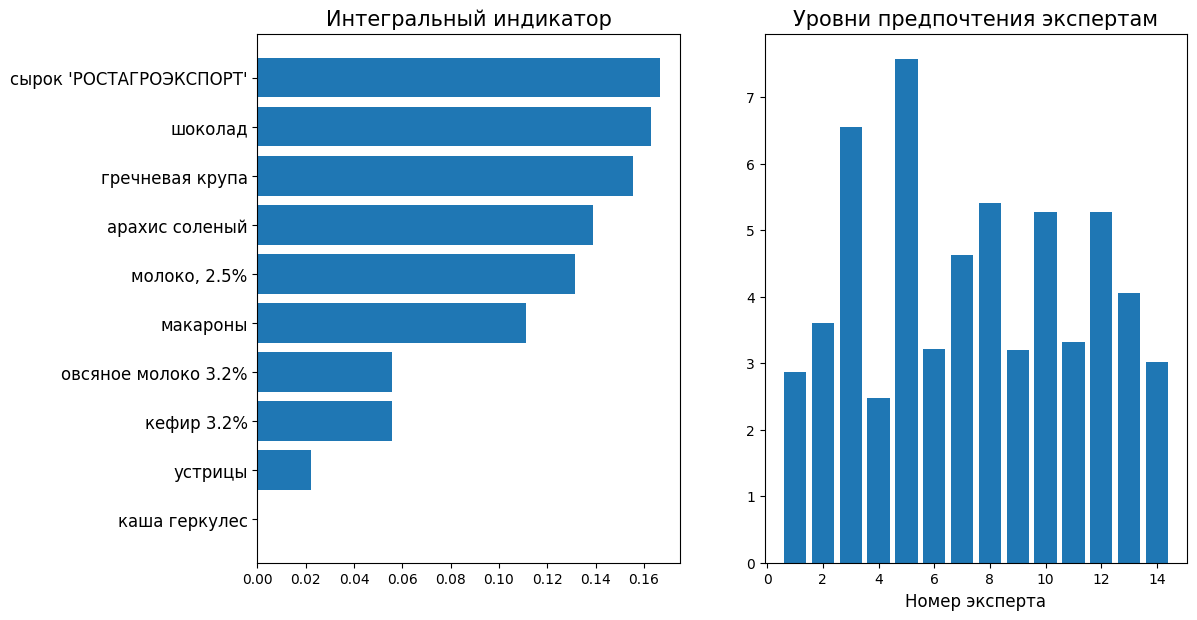

In [16]:
# интегральный индикатор
fig, ax = plt.subplots(ncols=2, figsize=(12, 7), dpi=100)
proc.build_int_ind(prob_bary2, ax[0], sort=True, fontsize=12)
ax[0].set_title('Интегральный индикатор', fontsize=15)
# ранжирование экспертов
alphas = dists_inv
y_pos = np.arange(len(alphas)) + 1
ax[1].bar(y_pos, alphas, align='center')
ax[1].set_title('Уровни предпочтения экспертам', fontsize=15)
ax[1].set_xlabel('Номер эксперта', fontsize=12)
plt.show()

### 2. Построение интегрального индикатора с заполнением пропуском $\frac{1}{10} = \frac{1}{N}$ 

In [18]:
exps_ranging = proc.extract_experts_ranging(const=0.1)
prob_bary = get_w_bary(exps_ranging)
dists_inv = 1./np.asarray(get_w_distances(prob_bary, exps_ranging))
prob_bary2 = get_w_bary(exps_ranging, alphas=dists_inv/np.sum(dists_inv))

Elapsed time : 0.46230125427246094 s
Elapsed time : 0.46330690383911133 s


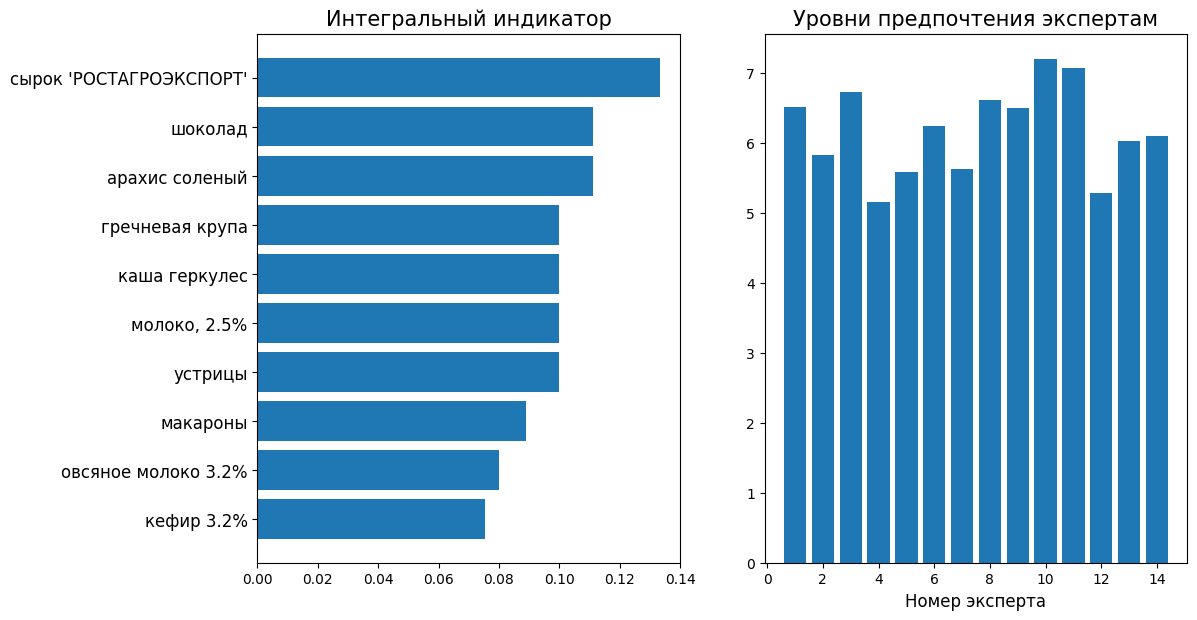

In [19]:
# интегральный индикатор
fig, ax = plt.subplots(ncols=2, figsize=(12, 7), dpi=100)
proc.build_int_ind(prob_bary2, ax[0], sort=True, fontsize=12)
ax[0].set_title('Интегральный индикатор', fontsize=15)
# ранжирование экспертов
alphas = dists_inv
y_pos = np.arange(len(alphas)) + 1
ax[1].bar(y_pos, alphas, align='center')
ax[1].set_title('Уровни предпочтения экспертам', fontsize=15)
ax[1].set_xlabel('Номер эксперта', fontsize=12)
plt.show()

### Сравнение с базовым интегральным индикатором

* $\beta_0$ (константа заполнения пропусков) = 0

Elapsed time : 0.35723328590393066 s
Elapsed time : 0.35823822021484375 s


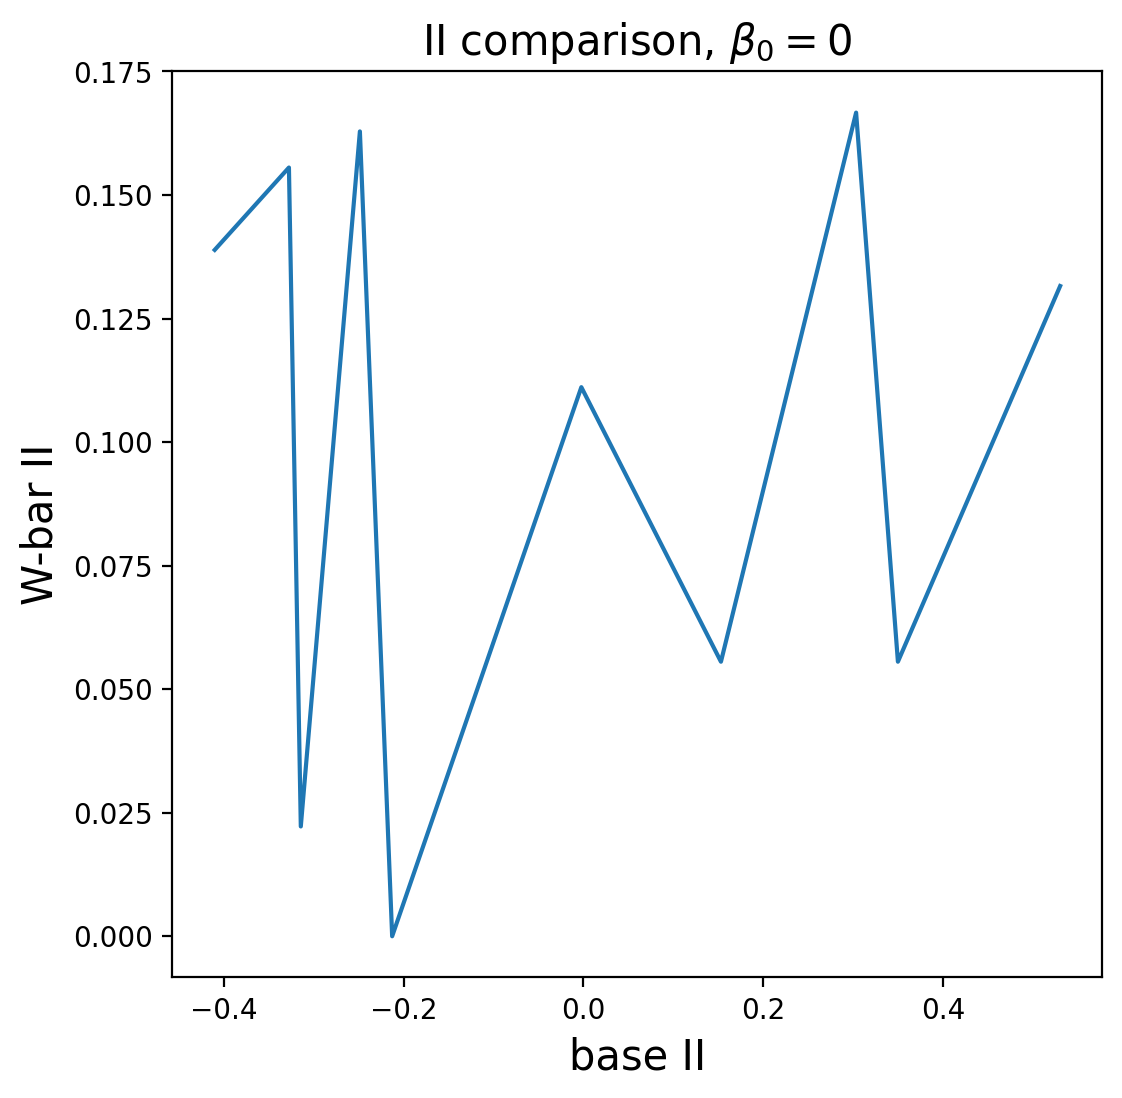

In [25]:
# here we obtain our integral indicator
exps_ranging = proc.extract_experts_ranging(const=0.0)
prob_bary = get_w_bary(exps_ranging)
dists_inv = 1./np.asarray(get_w_distances(prob_bary, exps_ranging))
prob_bary2 = get_w_bary(exps_ranging, alphas=dists_inv/np.sum(dists_inv))

# here we obtain base integral indicator
M = proc.get_kendall_matrix(const=0.0)
w, v = np.linalg.eig(M)
base_int_ind = v[:, 0]

#let's build comparison
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
inds = np.argsort(base_int_ind)
ax.plot(base_int_ind[inds], prob_bary2[inds])
ax.set_xlabel('base II', fontsize=15)
ax.set_ylabel('W-bar II', fontsize=15)
ax.set_title(r'II comparison, $\beta_0 = 0$', fontsize=15)
plt.show()


* $\beta_0 = \frac{1}{10}$

Elapsed time : 0.3522334098815918 s
Elapsed time : 0.35623764991760254 s


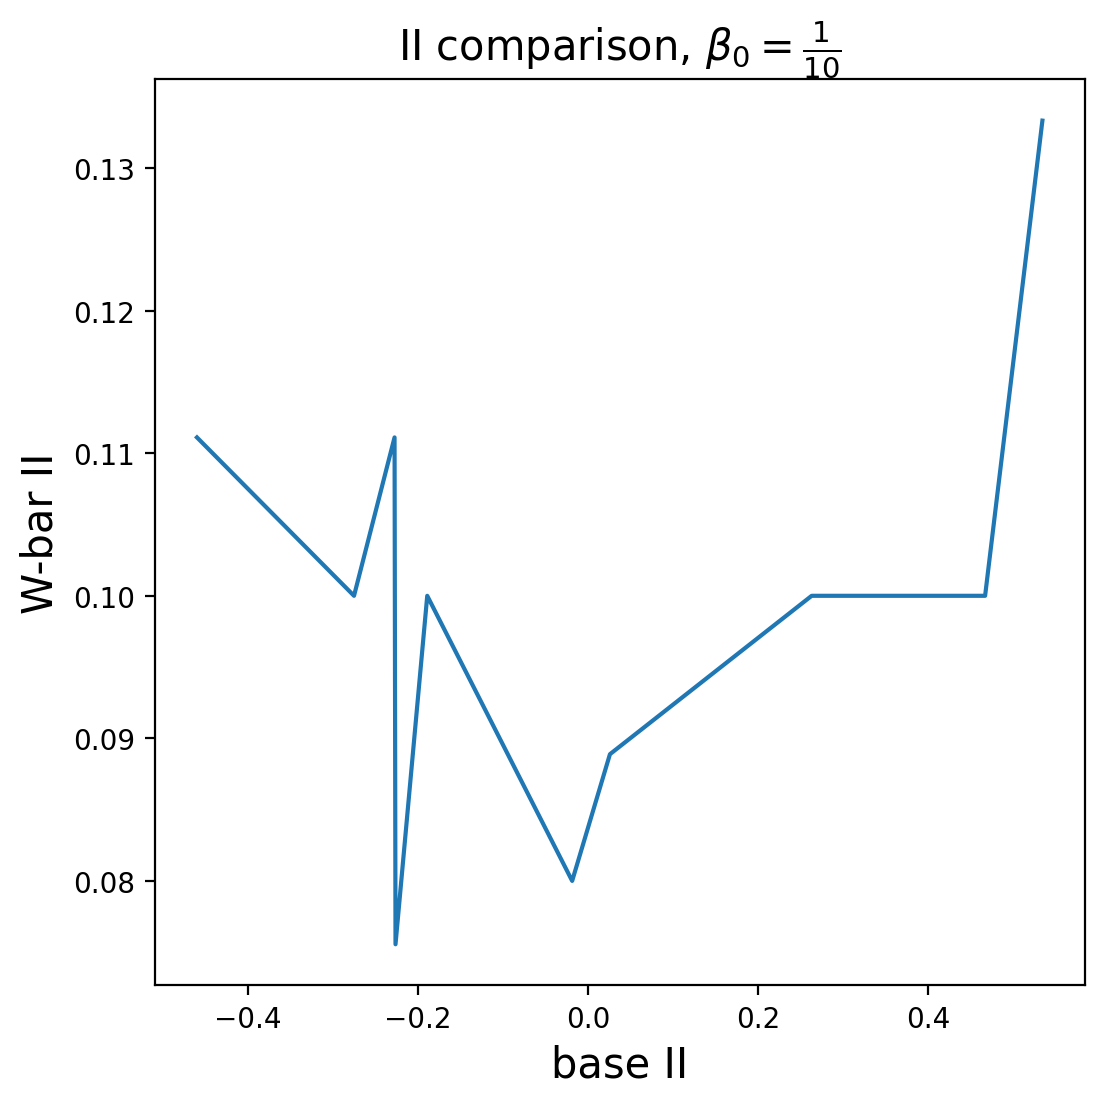

In [26]:
# here we obtain our integral indicator
exps_ranging = proc.extract_experts_ranging(const=0.1)
prob_bary = get_w_bary(exps_ranging)
dists_inv = 1./np.asarray(get_w_distances(prob_bary, exps_ranging))
prob_bary2 = get_w_bary(exps_ranging, alphas=dists_inv/np.sum(dists_inv))

# here we obtain base integral indicator
M = proc.get_kendall_matrix(const=0.1)
w, v = np.linalg.eig(M)
base_int_ind = v[:, 0]

#let's build comparison
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
inds = np.argsort(base_int_ind)
ax.plot(base_int_ind[inds], prob_bary2[inds])
ax.set_xlabel('base II', fontsize=15)
ax.set_ylabel('W-bar II', fontsize=15)
ax.set_title(r'II comparison, $\beta_0 = \frac{1}{10}$', fontsize=15)
plt.show()
